# Risk Scorecard Development:
> <font size =  "4"> This notebook describes the procedure to develop risk score and risk scorecard.</font>
## Risk Score:
> <font size =  "4"> A risk score is a numerical score that is derived from the statistical analysis and represents transactions riskiness. Higher risk score corresponds to high default probability. </font>

> <font size =  "4"> This concept of scorecard development is popular in finance industry. Various types of scores like risk scores, credit scores, credit rating are being developed in financial domain to understand credit risk, default risk, product pricing etc. Risk scores are usually developed using big data analytics and efficient machine learning algorithms, including, but not limited to, logistic regression, ensemble, and gradient boosting decision trees. </font>

## Developing the Risk Scores from predicted probabilities of developed model:
> <font size =  "4"> Once the machine learning model is assessed and finalized to be implemented in production, loan applicants risk scores and scorecard should be developed. These risk scores are further used to decide the score threshold for loan acceptance decisioning in real time. </font>

> <font size =  "4"> <font color='red'> Defining threshold for loan applicants acceptance decision, based on the developed models prediction probabilities will be challenging as transactions predicted probabilities will be tightly placed between small scale. So, it necessitates the scaling methodology which can scale the predicted probabilities to a large range of scores. </font> </font>

> <font size =  "4"> For developing risk scores, logistic regression is used as it assumes linearity between the dependent and the response variables. Lets first compute the risk score and then develop the risk scorecard. </font>

## 1. Risk Score Computation
#### Explanatory example:
> <font size =  "4"> Following simple example describes the steps along with the code for developing the risk score. This example is just for reference and you do not need to input your data in this code. </font>

<font size =  "4"> Following is a risk score development process flow: </font>

<font size =  "4">
    
1. Compute log of odds (log(good/bad)) of each transaction.
2. Train a logistic regression model on log of odds, target(default) labels and get intercept and slope of line which separates log of odds and log of target labels.
3. Develop risk scores by using log(odds), slope and intercept of logistic regression and by tuning PDO, score corresponding to 1% bad rate.
    </font>

### <font color='red'> Definitions: </font>
#### log of odds:
> <font size =  "4"> Ratio of apllicants chances of being good to bad is odds and its log is log of odds. These good and bad probabilities are developed models prediction probabilities.</font>
#### PDO:
> <font size =  "4"> Points to double the odds (PDO) define the score points by which odds double.</font>
#### Score corresponding to 1% bad rate:
> <font size =  "4"> Score value for 1% bad rate.</font>
#### Scaling:
> <font size =  "4"> <font color='red'> Scaling factors in the aligned score equation does not affect the predictive strength of the scorecard. scaling term 1 and scaling term 2 are used in the aligned score equation.</font> </font>
#### Intercept and Slope:
> <font size =  "4"> Slope and intercept of logistic regression line classifying log(odds) and fraud labels.</font>
#### Aligned score equation:
> <font size =  "4"> Developed aligned score equation which is linear function of log of odds.</font>

> <font color='red'> <font size =  "5"> $Aligned Score= \bigg[ Score Correponding To 1 Pct Bad Rate + \frac{ PDO}{ln(2)} * (Scaling Term 1 + intercept )\bigg] - \bigg[ \frac{ PDO}{ln(2)}*Slope*Scaling Term 2 * log(odds) \bigg]$ </font></font>


In [1]:
# Import the required libraries
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

! pip install ipywidgets
! jupyter nbextension enable --py widgetsnbextension

import ipywidgets as widgets

%matplotlib inline
from scipy.integrate import ode
from ipywidgets import *
from IPython.display import clear_output, display, HTML
import random
from sklearn.linear_model import LogisticRegression

# model_pickle_file
import pickle
from pickle import load

# Disbale the future warning in python
warnings.simplefilter(action='ignore', category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [18]:
def risk_score_example(example_points):
    """
    This function presents an example of risk score computation steps.
    Input: example_points - number of example points that you would like to use for this demo. Example points are good and bad points each.
    """

    # lets prepare the dataframe of these example points
    np.random.seed(10)
    bad_proba=np.random.uniform(0.3,1,example_points)  # example points which belongs to bad probability (Proba range = 0.3 to 1)
    bad_proba=np.append(bad_proba,np.random.uniform(0,0.7,example_points)) # example points which belongs to good probability (Proba range = 0 to 0.7) - exceptions
    good_proba=1-bad_proba
    fraud_1=[1]*example_points # 1 - good example points (fraud label)
    fraud_0=[0]*example_points # 0 - bad example points (fraud label)
    fraud=fraud_1+fraud_0
    fraud_1_s=["Good"]*example_points # 1 - good example points (fraud label)
    fraud_0_s=["Bad"]*example_points # 0 - bad example points (fraud label)
    fraud_s=fraud_1_s+fraud_0_s


    ## --------------------      1.	Compute log of odds (log(good/bad)) of each transaction.   ---------------------- ##
    odds=good_proba/bad_proba
    log_odds=np.log(odds)

    data={"good_proba":good_proba,
         "bad_proba":bad_proba,
         "fraud":fraud,
          "fraud_s":fraud_s,
          "odds":odds,
         "log_odds":log_odds
         }
    example_score_df = pd.DataFrame(data)


    ## ------------------  2. Lets build a logistic regression model on log(odds), fraud labels  -------------------- ##
    log_score = LogisticRegression(random_state=0, solver="lbfgs", max_iter = 1000).fit(pd.DataFrame(example_score_df['log_odds'])
                                , example_score_df['fraud'])

    print("-"*75)
    print("Logistic regressions Intercept and Slope are :")

     # Intercept value :
    print('Intercept:', log_score.intercept_.ravel())

    # Slope value :
    print('Slope:', log_score.coef_.ravel())

    # predicted probabilities
    lg_predicted_proba=log_score.predict_proba(np.array([example_score_df['log_odds'].to_list()]).reshape(-1,1))[:,0]
    lg_predicted_proba=1-lg_predicted_proba

    ## logistic regression classification line
    x_lg_line=[i for i in range(-4,5)]
    y_lg_line=log_score.coef_.ravel()*x_lg_line+log_score.intercept_.ravel()


    ## ----------------- 3.	Develop risk scores by using log(odds), slope and intercept of logistic regression and by tuning PDO, score corresponding to 1% bad rate. ------------------ ##
    # Following parameters needs to be tuned in the score computation process. For this example these are already tuned:
    Slope=log_score.coef_.ravel()  # logistic regression fit slope
    Intercept=log_score.intercept_.ravel()  # logistic regression fit intercept
    PDO=20  # points to double the odds
    score_corresponding_to_1pct_bad_rate= 500  # score corresponding to 1% bad rate
    Term_1_scaling_factor=math.log(89)  # Term 1 scaling factor
    Term_2_scaling_factor=0.7 # Term 2 scaling factor

    Aligned_score_term1=score_corresponding_to_1pct_bad_rate+((Term_1_scaling_factor+Intercept)*PDO/math.log(2))
    Aligned_score_term2=PDO*Slope/math.log(2)*Term_2_scaling_factor

    print("-"*75)
    print("Aligned Score Equation is= %5.3f - %5.3f*score" %(Aligned_score_term1,Aligned_score_term2))
#     print("-"*75)

#     print("-"*75)
    print("Score corresponding to 1% bad rate is " ,Aligned_score_term1-(Aligned_score_term2*4.59511985013459))
#     print("-"*75)

#     print("-"*75)
    print("Score corresponding to 2% bad rate is " ,Aligned_score_term1-(Aligned_score_term2*3.89182029811063))
    print("-"*75)

    example_score_df["Alligned_Score"]=Aligned_score_term1-(Aligned_score_term2*example_score_df["log_odds"])

    ## Plot the logistic regression fit and alligned score graphs
    fig = plt.figure(figsize=(10, 10))

    x = np.linspace(0., 5., 100)
    y = np.sin(x)

    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

    # Create second axes, the top-left plot with orange plot
    colors = {0:'tab:blue', 1:'tab:orange'}

    sub2 = fig.add_subplot(2,1,1) # two rows, two columns, first cell
    log_frauds_1=[math.log(0.99/(1-0.99))]*example_points
    log_frauds_0=[math.log(0.01/(1-0.01))]*example_points
    log_frauds=log_frauds_1+log_frauds_0
    sub2.scatter(example_score_df["log_odds"],log_frauds,label='log(Defaults) vs log(odds)')
    sns.scatterplot(x=example_score_df["log_odds"],y=log_frauds,hue=example_score_df["fraud_s"])
    sub2.plot(x_lg_line,y_lg_line,label='Clssification Line')
    sub2.set_ylabel("log(Defaults/(1-Defaults))")
    sub2.set_xlabel("log_odds")
    sub2.set_title("Logistic Regression Classification Representation")
    sub2.tick_params(labelrotation=90,labelsize = 7)
    sub2.legend(loc='upper left')
    sub2.set_ylim([log_frauds_0[0]-0.5, log_frauds_1[0]+0.5])
    sub2.grid()
    sub3 = sub2.twinx()
    sub3.scatter(example_score_df["log_odds"],lg_predicted_proba,label='lg Proba',color='r')
    sub3.set_ylabel("LR Predicted Proba")
    sub3.set_ylim([0,1])
    sub3.legend(loc='upper right')
    sub3.grid()

    sub1 = fig.add_subplot(2,1,2) # two rows, two columns, fist cell
    sns.regplot(x=example_score_df["log_odds"],y=example_score_df["Alligned_Score"],
                 line_kws=dict(alpha=0.2, color='red', linewidth=2))
    sns.scatterplot(x=example_score_df["log_odds"],y=example_score_df["Alligned_Score"],hue=example_score_df["fraud_s"])
    sub1.set_xlabel(" log_odds")
    sub1.set_ylabel("Alligned_Score")
    sub1.set_title("Alligned Score vs log(odds)")
    sub1.tick_params(labelrotation=90,labelsize = 7)
    sub1.set_ylim([example_score_df["Alligned_Score"].min()-20, example_score_df["Alligned_Score"].max()+20])
    sub1.grid()

    plt.show()

    print("-"*75)
    print("Example Dataframe is as follows :")

    example_score_df.rename(columns={'fraud':'Good_Applicant_Flag','fraud_s':'Applicants'},inplace=True)

    return(example_score_df)

---------------------------------------------------------------------------
Logistic regressions Intercept and Slope are :
Intercept: [0.02765529]
Slope: [-1.40055982]
---------------------------------------------------------------------------
Aligned Score Equation is= 630.313 - -28.288*score
Score corresponding to 1% bad rate is  [760.29997884]
Score corresponding to 2% bad rate is  [740.40494974]
---------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


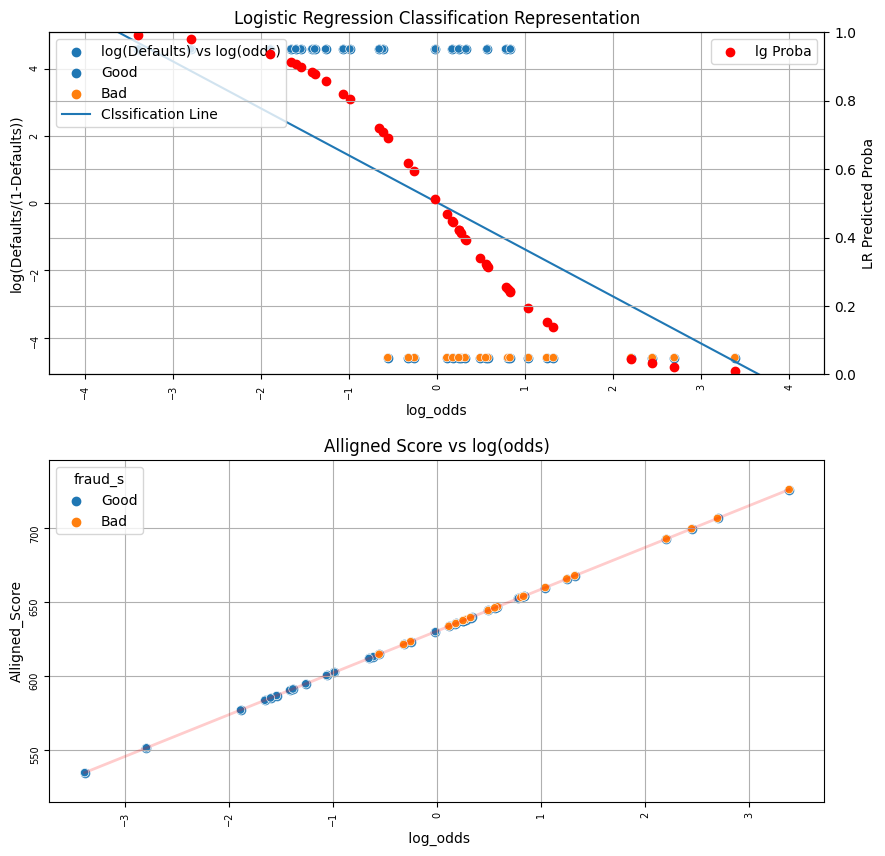

---------------------------------------------------------------------------
Example Dataframe is as follows :


,good_proba,bad_proba,Good_Applicant_Flag,Applicants,odds,log_odds,Alligned_Score
0,0.160076,0.839924,1,Good,0.190583,-1.657666,583.420359
1,0.685474,0.314526,1,Good,2.179384,0.779042,652.350277
2,0.256446,0.743554,1,Good,0.344893,-1.064522,600.199294
3,0.175837,0.824163,1,Good,0.213353,-1.544809,586.612875
4,0.351045,0.648955,1,Good,0.540939,-0.614449,612.931031
5,0.542642,0.457358,1,Good,1.186473,0.170985,635.149470
6,0.561356,0.438644,1,Good,1.279753,0.246667,637.290383
7,0.167629,0.832371,1,Good,0.201387,-1.602529,584.980094
8,0.581622,0.418378,1,Good,1.390185,0.329437,639.631792
9,0.638162,0.361838,1,Good,1.763669,0.567396,646.363207


In [19]:
risk_score_example(20)

## Observations :
1. Logistic regression line classifies good and bad appilcants.
2. Aligned score is linearly mapped for the log(odds).
3. Good applicants has lower risk scores than the bad/defaulter applicants.
4. Score corresponding to 1 pct bad rate is 760. Odds are doubling for 20 risk points which is PDO value. eg. Odds 29.46 (row no. 38) corresoponds to risk score of 726 and its halved odds 14.79 (row no. 34) corresponds to risk score of 706.
> <font size =  "4"> Note: In this example we have adjusted scaling term 1 and scaling term 2 in such a way that score corresponding to 1% bad rate and PDO observations are correctly followed. In the actual scorecard development our objective is to get a required distribution and stability of risk scorecard by tuning the PDO, score corresponding to 1% bad rate, scaling term 1 and scaling term 2 which may not result in following the PDO and score corresponding to 1% bad rate as observed here.</font>